# Data Analysis Notebook

This notebook contains code for an interactive GUI that can run the lick detection algorithm and display results. It is based on the MATLAB lickDetector.m script, and all code for the analysis algorithms is contained in data_analysis.py.

## Initial Setup

### Imports

In [1]:
import os
import re
import glob
from datetime import datetime
import h5py
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Widget stuff
#import ipywidgets as widgets
import panel as pn
pn.extension()

# Plotting
import matplotlib.pyplot as plt

# Lick detection algorithm
from data_analysis import filter_data

### Load data

In [2]:
# Set the directory where data is stored (and where analysis files will be written)
data_dir = "Lickometry Data/AEW2"
animal_id_prefix = data_dir.split('/')[1] # we will use this prefix in the final combined results filename

In [3]:
# TODO: File picker GUI for selecting the animal-sensor map file
# For now it assumes the file is named layout.csv and stored with the data
layout = pd.read_csv(os.path.join(data_dir, "layout.csv"), header=None, index_col=0)

In [4]:
fs = pn.widgets.FileSelector(
    directory=data_dir,
    only_files=True,
    file_pattern="*.h5",
)

pn.Column(
    "Select raw data files (click and drag for multiselect). Click the '>>' button to add file(s) to the list to process. Do not re-run the cell after selection or you'll need to select them again!",
    fs,
    pn.pane.Markdown("### Selected:\n" + "\n".join(fs.value) if fs.value else "### Selected:\n(none)")
)

Column
    [0] Markdown(str)
    [1] FileSelector(directory='/Users/christopher/TimmeL..., file_pattern='*.h5', only_files=True, root_directory='/Users/christopher/TimmeL...)
    [2] Markdown(str)

### Start/Stop Times Visualization
If the script gives any warnings about start and stop times while running the analysis, it can be useful to plot the traces with start/stop times labeled. Then you can create time_fix.xlsx in the data directory to override the start/stop times stored in the raw data files.

Total recording length: 7641.752587795258 seconds (127.36254312992097 minutes)


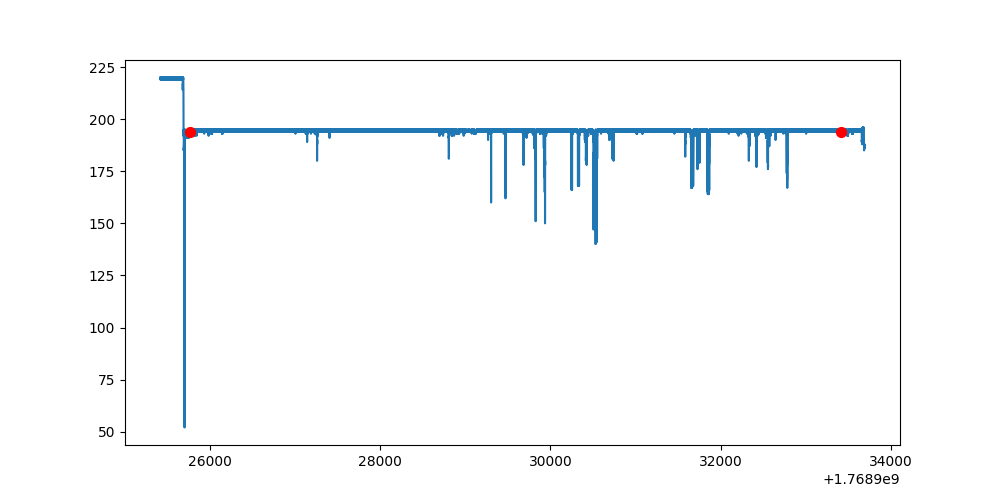

In [10]:
# Time fixes
#   An excel sheet can be used if there are errors in the start
#   and stop times. The user will be able to override the start/stop times
#   recorded and use the capacitance traces to identify start and stop
#   times. This file will have three columns, with headers:
#   Sensor, New Start Time, New End Time. The code will produce
#   plots for the user and data tips can be used identify new start and
#   stop times. The time fix file should be named the same base filename as
#   the corresponding raw data, but with _time_fix.xlsx at the end (so
#   raw_data_2026-01-20_11-10-18.h5 corresponds to
#   raw_data_2026-01-20_11-10-18_time_fix.xlsx). Example time fix file format:
#
#   Sensor    New Start Time      New End Time
#   20        1756825855          1756833056
#   2         1757083015          1757090258
#
#   This would be time fixes for two recordings.
#
# To plot a capacitive trace, change the change the filename listed and the sensor number,
# then re-run this cell. This is useful for determining start/stop times for the file.
# The matplotlib widget backend has been enabled so that you can move around the graph and zoom.
#
# In general, this step can be skipped until a problem is encountered. The automated analysis will
# account for accidental start/stops and use the last start_time/stop_time pair in the file. However,
# if no start or stop time is recorded, this can be used to fix that situation.
file = os.path.join(data_dir, "raw_data_2026-01-20_11-10-18.h5")
sensor = 1

# Determine which board did the recording based on sensor number
match sensor:
    case (1 | 2 | 3 | 7 | 8 | 9):
        board = 0
    case (4 | 5 | 6 | 10 | 11 | 12):
        board = 1
    case (13 | 14 | 15 | 19 | 20 | 21):
        board = 2
    case (16 | 17 | 18 | 22 | 23 | 24):
        board = 3

with h5py.File(file, 'r') as h5f:
    sensor_data = h5f[f'board_FT232H{board}'][f'sensor_{sensor}']
    cap_data = sensor_data['cap_data'][()]
    time_data = sensor_data['time_data'][()]

    # Determine which start time keys we have
    pattern = re.compile(r'^start_time(\d+)?$')
    matches = {}
    for k in sensor_data.keys():
        m = pattern.match(k)
        if m:
            num = int(m.group(1)) if m.group(1) else -1
            matches[num] = k
    if matches:
        num = -np.inf
        for n in matches.keys():
            if n > num: num = n
        last_start = matches[num]
        start_time = sensor_data[last_start][()]
        # Try the stop_time corresponding to the start_time above
        try:
            stop_time = sensor_data['stop' + last_start[5:]][()]
        except KeyError:
            # Stop time wasn't recorded (likely clicked stop all button too soon)
            stop_time = time_data[-1]
    else: # no start time recorded
        start_time = time_data[0] # start at beginning
        stop_time = time_data[-1] # stop at end    

total_recording_time = stop_time - start_time
print(f"Total recording length: {total_recording_time} seconds ({total_recording_time/60} minutes)")
start_idx = np.argmin(
    np.abs(time_data - start_time)
)
stop_idx = np.argmin(
    np.abs(time_data - stop_time)
)

%matplotlib widget
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time_data, cap_data, zorder=0)
ax.scatter(start_time, cap_data[start_idx], marker='o', c='r', s=50, zorder=1)
ax.scatter(stop_time, cap_data[stop_idx], marker='o', c='r', s=50, zorder=2)

## Run Analysis

In [5]:
# Loop through data files and run the filter_data script on them
missing_data_files = []
for raw_data_filename in fs.value:
    print(f"Working on file: {raw_data_filename}")
    raw_data_filename_base = os.path.basename(raw_data_filename)
    
    filtered_data_filename_base = "filtered" + raw_data_filename_base[3:]
    filtered_data_filename = os.path.join(os.path.dirname(raw_data_filename), filtered_data_filename_base)
    
    time_fix_filename = raw_data_filename[:-3] + "_time_fix.xlsx"
    
    with h5py.File(raw_data_filename, 'r') as raw_h5, h5py.File(filtered_data_filename, 'w') as filtered_h5:
        try:
            print(f"Comments from current raw data file:")
            print(raw_h5['comments'][()] + "\n")
        except KeyError:
            print("No comments in metadata\n")
        # Check if there's a corresponding time fix file and pass it, if so
        if os.path.exists(time_fix_filename):
            missing_data = filter_data(raw_h5, filtered_h5, layout, raw_data_filename[:-3] + '.log', time_fix=pd.read_excel(time_fix_filename, index_col=False, header=0), algorithm="basic_threshold")
        else:
            missing_data = filter_data(raw_h5, filtered_h5, layout, raw_data_filename[:-3] + '.log', algorithm="basic_threshold")
    if missing_data:
        missing_data_files.append(raw_data_filename)
        print(f"Skipping file {raw_data_filename} due to missing data\n")

    else: print("") # newline between files
for f in missing_data_files:
    fs.value.remove(f)

Working on file: /Users/christopher/TimmeLab/Capacitive-Lick-Detection/Lickometry Data/AEW2/raw_data_2025-05-12_14-10-36.h5
Comments from current raw data file:
No comments in metadata

Animal AEW2-1 had 511 licks detected
Animal AEW2-2 had 4 licks detected
Animal AEW2-3 had 552 licks detected
Animal AEW2-4 had 448 licks detected
Animal AEW2-5 had 603 licks detected
Animal AEW2-6 had 168 licks detected
Animal AEW2-7 had 306 licks detected
Animal AEW2-8 had 566 licks detected
Animal AEW2-9 had 222 licks detected
Animal AEW2-10 had 291 licks detected
Animal AEW2-11 had 423 licks detected
Animal AEW2-12 had 387 licks detected
Animal AEW2-13 had 363 licks detected
Animal AEW2-14 had 370 licks detected
Animal AEW2-15 had 272 licks detected
Animal AEW2-16 had 416 licks detected
Animal AEW2-17 had 668 licks detected
Animal AEW2-18 had 454 licks detected
Animal AEW2-19 had 329 licks detected
Animal AEW2-20 had 291 licks detected
Animal AEW2-21 had 388 licks detected
Animal AEW2-22 had 338 lick

## Combine Results by Animal

In [7]:
# Get the dates of the raw data files, so we can get a list of dates analyzed to put in the combined filename
dates = []
date_range = []
pattern = r'raw_data_(\d{4}-\d{2}-\d{2})_'
for raw_data_filename in fs.value:
    match = re.search(pattern, raw_data_filename)
    if match: date = match.group(1)
    dates.append(date)

In [8]:
# Parse the dates and create a list of dates analyzed
parsed = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

year_tmp = parsed[0].year
month_tmp = parsed[0].month
# Add the first date in full to the date range
date_range.append(parsed[0].strftime("%Y-%m-%d"))
for date in parsed[1:]:
    # Same month and year
    if date.year == year_tmp and date.month == month_tmp:
        date_range.append(date.strftime("%d"))
    elif date.year == year_tmp:
        month_tmp = date.month
        date_range.append(date.strftime("%m-%d"))
    else:
        year_tmp = date.year
        month_tmp = date.month
        date_range.append(date.strftime("%Y-%m-%d"))

# Join the dates to a string for the combined filename
date_range = "_".join(date_range)

# Combined filename
combined_filename = f"results_combined_{animal_id_prefix}_{date_range}.h5"
combined_filepath = os.path.join(data_dir, combined_filename)

In [9]:
for animal_id in layout.values:
    animal_id = animal_id[0]
    weights_tmp = {}
    vols_tmp = {}
    lick_indices_tmp = {}
    lick_times_tmp = {}

    # Start the combined h5 file
    with h5py.File(combined_filepath, 'a') as h5f:
        grp = h5f.create_group(animal_id)
        for i,raw_data_filename in enumerate(fs.value):
            # Because the number of licks will likely vary, we can't just use arrays
            # for the datasets (like a 4x500 array for 4 files and 500 licks). Instead
            # we'll use a dict-like structure with a subgroup for each file
            grp2 = grp.create_group(str(i))
            raw_data_filename_base = os.path.basename(raw_data_filename)
            filtered_data_filename_base = "filtered" + raw_data_filename_base[3:]
            filtered_data_filename = os.path.join(os.path.dirname(raw_data_filename), filtered_data_filename_base)
            
            #try:
            with h5py.File(filtered_data_filename, 'r') as h5f:
                try:
                    grp2.create_dataset('weights', data=h5f[animal_id]['weight'][()])
                    grp2.create_dataset('consumed_vols', data=h5f[animal_id]['consumed_vol'][()])
                except KeyError:
                    # If weight or volume consumed wasn't properly recorded, we must skip the file
                    continue
                grp2.create_dataset('lick_indices', data=h5f[animal_id]['lick_indices'][()])
                grp2.create_dataset('lick_times', data=h5f[animal_id]['lick_times'][()])
                grp2.create_dataset('cap_data', data=h5f[animal_id]['cap_data'][()])
                grp2.create_dataset('time_data', data=h5f[animal_id]['time_data'][()])
                grp2.create_dataset('used_start_idx', data=h5f[animal_id]['used_start_idx'][()])
                grp2.create_dataset('used_stop_idx', data=h5f[animal_id]['used_stop_idx'][()])

### Remove Intermediate Files

In [10]:
for f in glob.glob(os.path.join(data_dir, "filtered_*.h5")):
    os.remove(f)

## Visualization

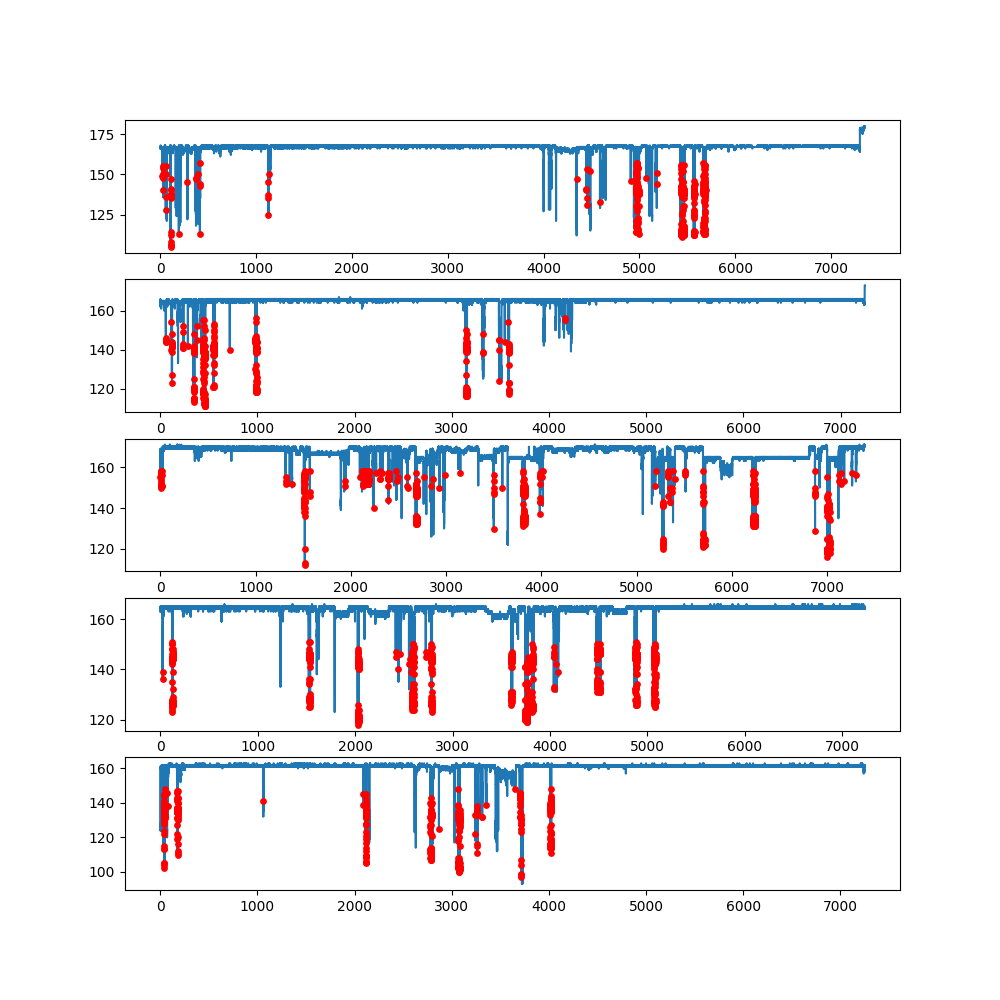

In [11]:
# Select the animal of interest and this cell will plot the full
# capacitive trace and place a red dot on each detected lick.
# This assumes you've selected the appropriate raw data files and run
# the analysis so the corresponding results_combined...h5 file exists
# and has its filename stored in combined_filename
animal_id = "AEW2-1"

with h5py.File(combined_filepath, 'r') as h5f:
    animal_data = h5f[animal_id]
    cap_data = {}
    time_data = {}
    lick_indices = {}
    for grp_num, grp_data in animal_data.items():
        grp_num = int(grp_num)
        cap_data[grp_num] = grp_data['cap_data'][()]
        time_data[grp_num] = grp_data['time_data'][()]
        lick_indices[grp_num] = grp_data['lick_indices'][()]

%matplotlib widget
fig, ax = plt.subplots(nrows=len(cap_data),figsize=(10,10))
for i in range(len(cap_data)):
    ax[i].plot(time_data[i], cap_data[i], zorder=0)
    ax[i].scatter(time_data[i][lick_indices[i]], cap_data[i][lick_indices[i]], marker='o', c='r', s=15, zorder=1)
plt.show()

## Correlation

In [12]:
# Gather arrays n_licks and vol_consumed (with shape n_animals x n_files) for correlation
n_animals = len(layout.values)
n_files = len(fs.value)

n_licks = np.zeros((n_files, n_animals))
vol_consumed = np.zeros((n_files, n_animals))

for i,animal_id in enumerate(layout.values):
    animal_id = animal_id[0]
    with h5py.File(combined_filepath, 'r') as h5f:
        animal_data = h5f[animal_id]
        for grp_num, grp_data in animal_data.items():
            grp_num = int(grp_num)
            vol_consumed[grp_num,i] = grp_data['consumed_vols'][()]
            n_licks[grp_num,i] = grp_data['lick_indices'][()].size

In [13]:
# Helper functions to replicate some MATLAB behavior from lickDetector.m
def mad_based_outliers(r, thresh=3.0):
    """
    Like MATLAB isoutlier, based on median absolute deviation
    Flag points where |r - median(r)| > thresh * (1.4826 * MAD).
    """
    r = np.asarray(r, dtype=float)
    med = np.median(r)
    mad = np.median(np.abs(r - med))
    if mad == 0:
        return np.zeros_like(r, dtype=bool)
    sigma = 1.4826 * mad # from definition of MAD
    return np.abs(r - med) > thresh * sigma


def linear_index_to_row_col(idx0, n_files):
    """
    MATLAB code:
        exclude = [ceil(outlier/nFiles), rem(outlier,nFiles)];
        exclude(exclude(:,2) == 0,2) = nFiles;
    where outlier is 1-based.

    Here idx0 is 0-based. Returns (row0, col0) 0-based indices matching
    data[row][col][...].
    """
    col0 = idx0 // n_files
    row0 = idx0 % n_files
    return row0, col0


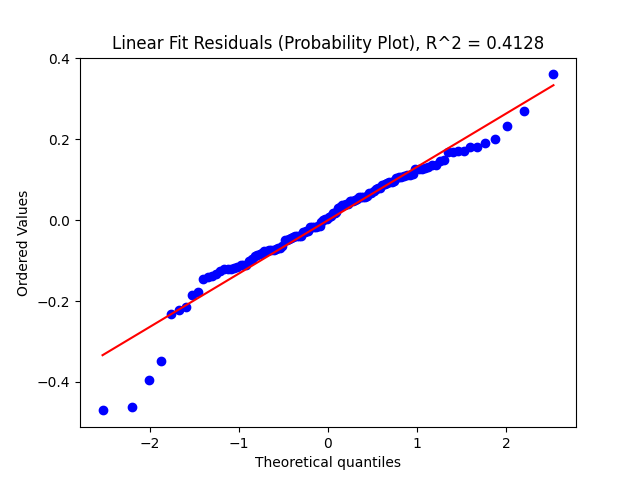

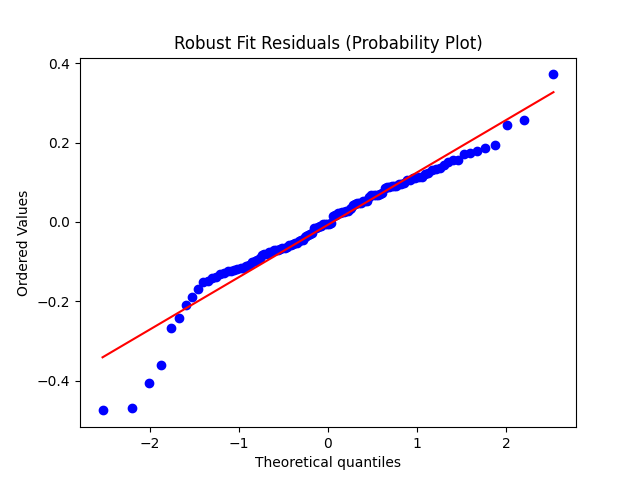

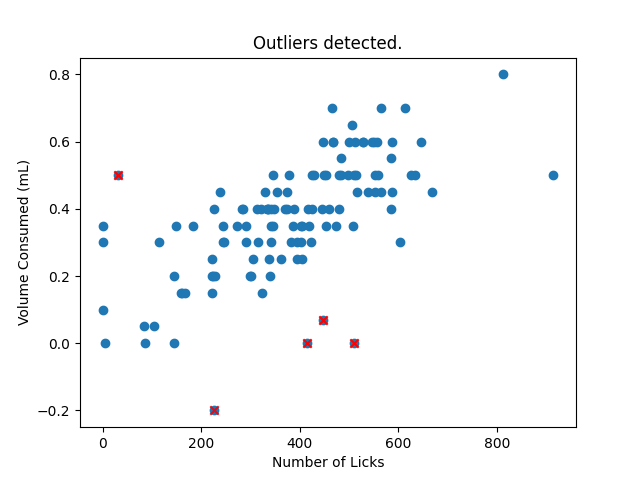

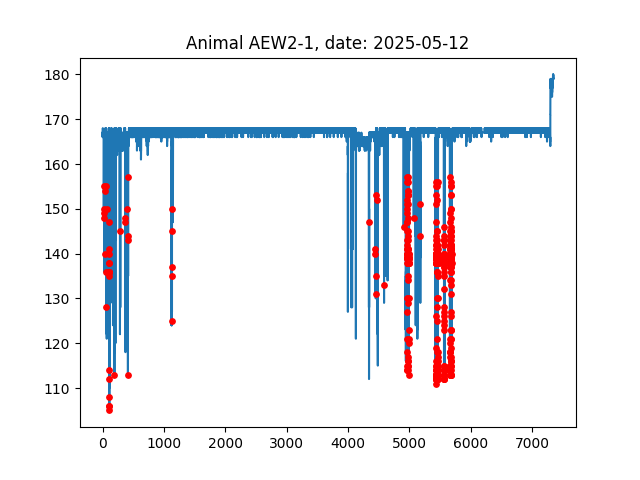

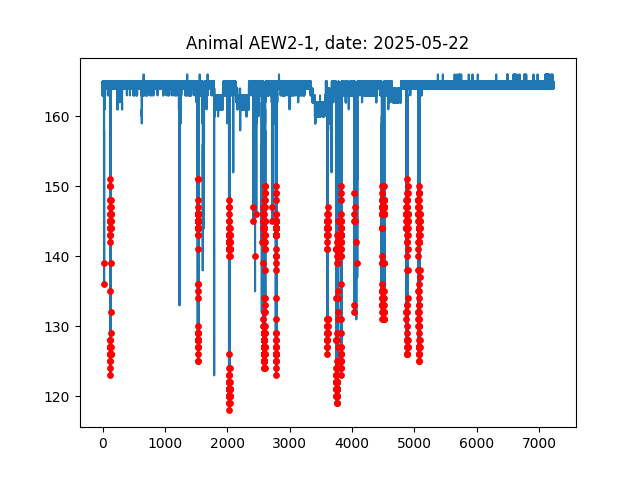

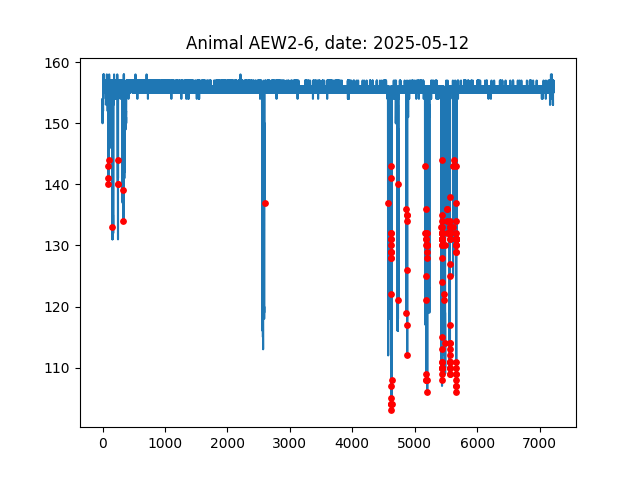

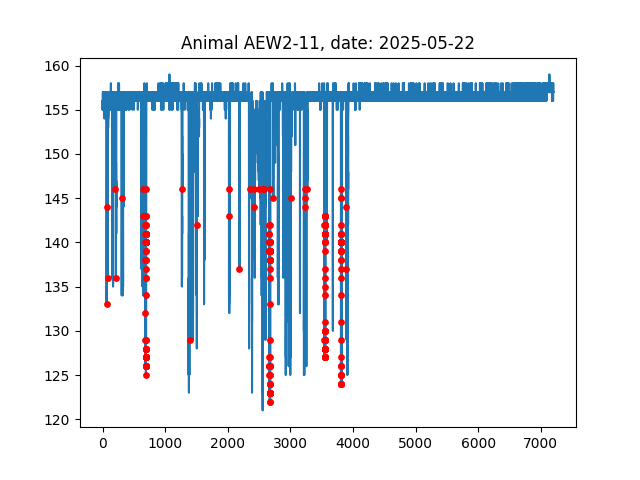

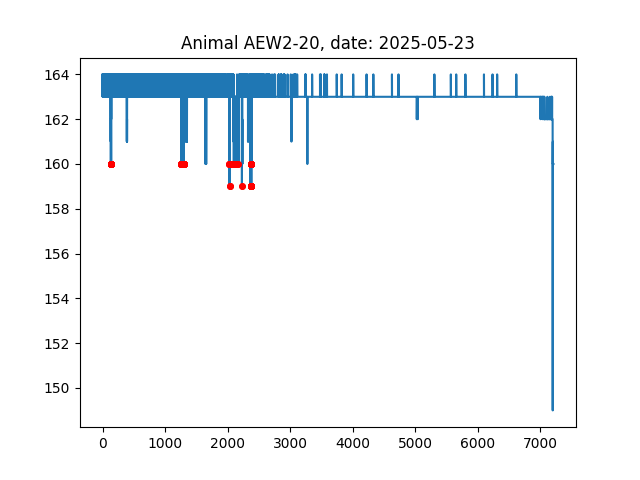

In [14]:
# Linear model (OLS)
X = sm.add_constant(n_licks.ravel())
y = vol_consumed.ravel()
mdl = sm.OLS(y, X).fit()

# Robust linear model (RLM)
mdlr = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

# Residuals from robust fit (raw residuals)
yhat_r = mdlr.predict(X)
resid_r = y - yhat_r

# Residual probability plots
plt.figure()
stats.probplot(mdl.resid, dist="norm", plot=plt)
plt.title(f"Linear Fit Residuals (Probability Plot), R^2 = {mdl.rsquared:.4f}")

plt.figure()
stats.probplot(resid_r, dist="norm", plot=plt)
plt.title("Robust Fit Residuals (Probability Plot)")

# Detect outliers in robust residuals
is_out = mad_based_outliers(resid_r, thresh=3.0)
outlier_idx0 = np.flatnonzero(is_out)  # 0-based indices into flattened x/y

# Show outliers to the user
if outlier_idx0.size > 0:
    plt.figure()
    plt.scatter(n_licks.ravel(), y)
    plt.scatter(n_licks.ravel()[outlier_idx0], y[outlier_idx0], marker="x", c="r")
    plt.title("Outliers detected.")
    plt.xlabel("Number of Licks")
    plt.ylabel("Volume Consumed (mL)")

    # Reorganize outlier info into (row, col) indices for data access
    # MATLAB exclude is [col, row] (1-based). We'll store 0-based (row0, col0).
    exclude = np.array([linear_index_to_row_col(i, n_files) for i in outlier_idx0], dtype=int)

    # Plot capacitance traces for excluded channels
    # MATLAB:
    #   plot(data{row,col,9}, data{row,col,8})
    # Python 0-based: data[row][col][8] and [7] if you stored the same ordering,
    # but to mirror MATLAB's 9 and 8, use [8] and [7] only if you kept the same.
    # Below assumes data[row][col][8] == MATLAB {...,9} and data[row][col][7] == MATLAB {...,8}.
    with h5py.File(combined_filepath, 'r') as h5f:
        for row0, col0 in exclude:
            file_num = row0
            animal_num = col0 + 1 # Animals IDs are 1-indexed
            animal_id = animal_id_prefix + "-" + str(animal_num)
            animal_data = h5f[animal_id]
            single_day_data = animal_data[str(file_num)]

            plt.figure()
            t = single_day_data['time_data'][()]
            v = single_day_data['cap_data'][()]
            lick_indices = single_day_data['lick_indices'][()]
            plt.plot(t, v, zorder=0)
            plt.scatter(t[lick_indices], v[lick_indices], marker='o', c='r', s=15, zorder=1)
            plt.title(f"Animal {animal_id}, date: {dates[file_num]}")